In [19]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [20]:

bag = rosbag.Bag('/home/uware/rosbags/16h5_slz_2-4-6-8-10_1080_20.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8,10]

In [21]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [22]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,21.469713
1,6.014745,21.914616
2,6.470302,10.005499
3,7.008150,12.913182
4,8.208525,12.710668
...,...,...
309,118.938588,10.356008
310,119.208170,4.322590
311,120.505038,9.983605
312,122.124307,12.850130


<AxesSubplot:xlabel='relative_time'>

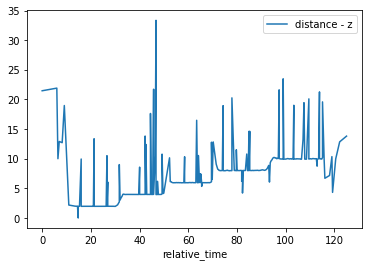

In [23]:
# initial graph
df.plot(x='relative_time', y=target)

In [24]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [25]:
# the amount of data points we are left with
len(x[peaks])

51

In [26]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

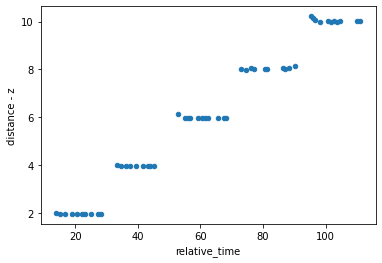

In [27]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [28]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
11,13.899413,1.998196,2
16,15.051837,1.980402,2
21,16.688550,1.976799,2
25,18.963935,1.982927,2
30,20.724754,1.975869,2
35,22.205654,1.973587,2
38,23.139345,1.978692,2
42,24.973299,1.982815,2
50,27.252372,1.984227,2
52,28.226442,1.981667,2


In [29]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [30]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [31]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
11,13.899413,1.998196,2,0.001804
16,15.051837,1.980402,2,0.019598
67,33.508228,4.028274,4,-0.028274
71,34.764632,3.979897,4,0.020103
121,52.911845,6.137686,6,-0.137686
128,55.103293,5.978306,6,0.021694
182,73.000362,8.017657,8,-0.017657
188,74.592576,7.992094,8,0.007906
247,95.310727,10.215556,10,-0.215556
249,95.966182,10.157685,10,-0.157685


In [32]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,10.0,0.018482,0.006795,0.001804,0.017101,0.018966,0.022728,0.026413
4,9.0,0.014800,0.016819,-0.028274,0.014448,0.019266,0.024205,0.026532
6,11.0,0.014206,0.051124,-0.137686,0.018869,0.030659,0.036495,0.039635
8,10.0,-0.037437,0.041110,-0.132538,-0.048378,-0.027927,-0.013138,0.007906
10,11.0,-0.042777,0.077333,-0.215556,-0.048999,-0.021582,-0.001750,0.037389


In [33]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

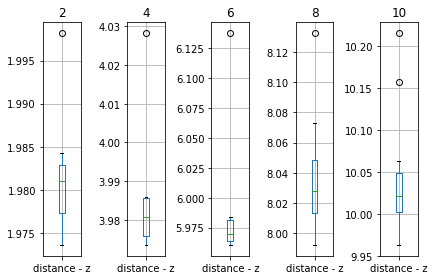

In [34]:
box_plotter(target)

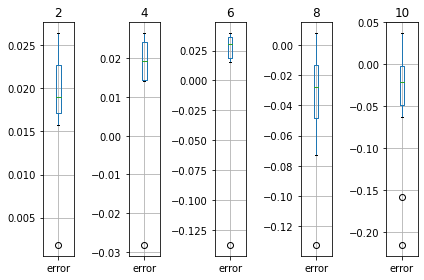

In [35]:
box_plotter('error')